## Problem 2. MNIST

__Name: Qi Zheng__  
__GTID: qzheng61__  


### Notes:
__Results are summarized at the beginning of each section.__

## 1. Create a modified training set
__For each image in the train set, generate two images where the probability of a pixel value being flipped is 0.03.
The size of the new training set is 120K.__

In [35]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from sklearn.metrics import mean_squared_error

In [36]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [37]:
(x_train, _), (x_test, _) = mnist.load_data()

In [38]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [39]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [40]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


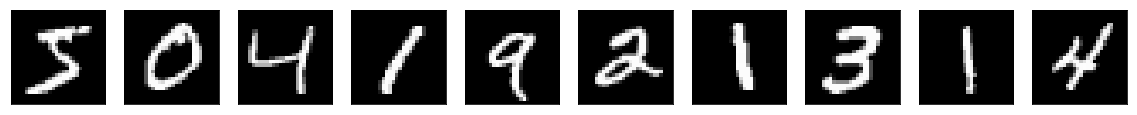

In [41]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [42]:
x_test_noisy = np.copy(x_test)

# Tile 2 training inputs to generate 120k training set
x_train_noisy = np.concatenate((x_train, x_train))

# Add noise to both training and testing data sets
mask1 = np.random.random_sample((120000, 28, 28, 1))
mask1[mask1<0.03]=1
x_train_noisy[mask1==1] = 1-x_train_noisy[mask1==1]

mask2 = np.random.random_sample((10000, 28, 28, 1))
mask2[mask2<0.03]=1
x_test_noisy[mask2==1] = 1-x_test_noisy[mask2==1]

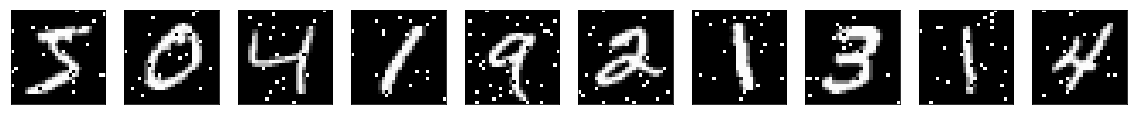

In [43]:
# Plot the first 10 images with added noises
# to check the results of flipping 3% pixel values.
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Build Autoencoder using Keras


__In this section, CNN architecture has been varied in four ways. CNN1 is the base case. CNN2 changed # of filters. CNN3 changed the optimizer. CNN4 changed # of layers.__  

__The test set error (mean L2 error) has also been plotted as a function of the number of samples (since # of samples is proportional to # of epoch, the plots are generated as "MSE vs epoch". This should be fine accroding to TA.)__  

__Finally, for each case, the best 10 and worst 10 reconstructed images have been plotted for each CNN architecture. Their corresponding original images have also been plotted in line with them for comparison.__

## CNN 1 (base case)

In [16]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [17]:
autoencoder.fit(x_train_noisy, np.concatenate((x_train, x_train)),
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')],
                verbose=2)

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
262s - loss: 0.1229 - mean_squared_error: 0.0200 - val_loss: 0.0889 - val_mean_squared_error: 0.0087
Epoch 2/10
257s - loss: 0.0847 - mean_squared_error: 0.0075 - val_loss: 0.0818 - val_mean_squared_error: 0.0065
Epoch 3/10
259s - loss: 0.0798 - mean_squared_error: 0.0060 - val_loss: 0.0779 - val_mean_squared_error: 0.0054
Epoch 4/10
261s - loss: 0.0774 - mean_squared_error: 0.0053 - val_loss: 0.0773 - val_mean_squared_error: 0.0052
Epoch 5/10
260s - loss: 0.0759 - mean_squared_error: 0.0049 - val_loss: 0.0753 - val_mean_squared_error: 0.0047
Epoch 6/10
258s - loss: 0.0748 - mean_squared_error: 0.0045 - val_loss: 0.0748 - val_mean_squared_error: 0.0045
Epoch 7/10
257s - loss: 0.0739 - mean_squared_error: 0.0043 - val_loss: 0.0727 - val_mean_squared_error: 0.0039
Epoch 8/10
260s - loss: 0.0733 - mean_squared_error: 0.0041 - val_loss: 0.0722 - val_mean_squared_error: 0.0038
Epoch 9/10
256s - loss: 0.0727 - mean_squared_error: 

In [97]:
def mse_plot(plt_title, test_mse):
    x = np.array(range(test_mse.size))+1
    plt.figure()
    plt.plot(x, test_mse, 'o-')
    plt.xlabel('Epoch')
    plt.xticks(x)
    plt.ylabel('Test Set MSE')
    plt.title(plt_title)
    plt.show()            

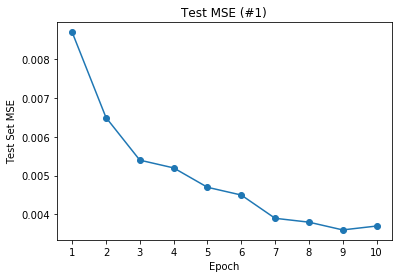

In [98]:
test1_mse = np.array([0.0087, 0.0065, 0.0054, 0.0052, 0.0047, 0.0045, 0.0039, 0.0038, 0.0036, 0.0037])
mse_plot("Test MSE (#1)", test1_mse)

In [94]:
def plot_img(n, decoded_imgs, x_noisy):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n+1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

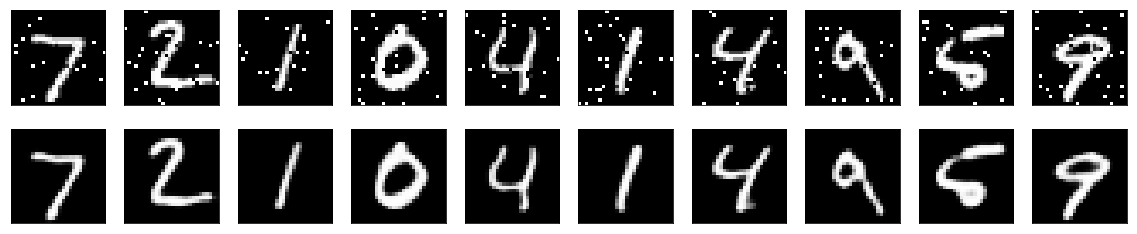

In [95]:
decoded_imgs = autoencoder.predict(x_test_noisy)
plot_img(10, decoded_imgs, x_test_noisy)

In [16]:
def mse_gen(x_test, x_pred):
    mse=np.zeros(10000)
    for i in range(10000):
        r = x_test[i].reshape(28, 28)
        p = x_pred[i].reshape(28, 28)
        mse[i] = mean_squared_error(r, p)
    max10 = mse.argsort()[::-1]
    min10 = mse.argsort()
    max10 = max10[:10]
    # print(max10)
    min10 = min10[:10]
    # print(min10)
    return min10, max10

In [17]:
def plt_best_worst(n, x_test, x_pred, indmx, title):
    plt.figure(figsize=(20, 4))
    print('\n'+title+'\n')
    print("Row 1: Original Images")
    print("Row 2: Reconstructed Images")

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        ind = indmx[i]
        plt.imshow(x_test[ind].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display predicted
        ax = plt.subplot(2, n, i + n +1)
        plt.imshow(x_pred[ind].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [124]:
min10, max10 = mse_gen(x_test, x_pred)


Best 10

Row 1: Original Images
Row 2: Reconstructed Images


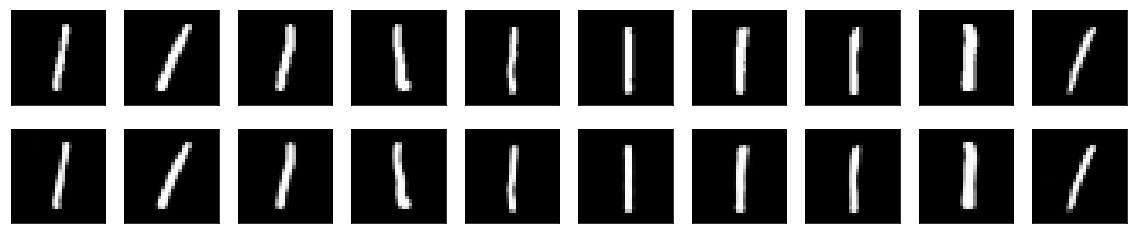

In [128]:
plt_best_worst(10, x_test, x_pred, min10, "Best 10")


Worst 10

Row 1: Original Images
Row 2: Reconstructed Images


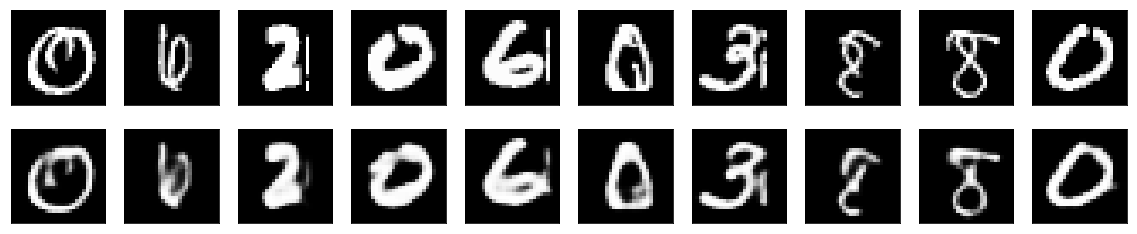

In [129]:
plt_best_worst(10, x_test, x_pred, max10, "Worst 10")

## CNN 2 (# of filters changed)

In [10]:
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x2 = MaxPooling2D((2, 2), padding='same')(x2)
x2 = Conv2D(16, (3, 3), activation='relu', padding='same')(x2)  # Filter number changed
encoded2 = MaxPooling2D((2, 2), padding='same')(x2)

x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded2)
x2 = UpSampling2D((2, 2))(x2)
x2 = Conv2D(16, (3, 3), activation='relu', padding='same')(x2)
x2 = UpSampling2D((2, 2))(x2)
decoded2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x2)

autoencoder2 = Model(input_img, decoded2)
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [11]:
autoencoder2.fit(x_train_noisy, np.concatenate((x_train, x_train)),
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder2')],
                verbose=2)

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
251s - loss: 0.1287 - mean_squared_error: 0.0219 - val_loss: 0.0886 - val_mean_squared_error: 0.0092
Epoch 2/10
248s - loss: 0.0853 - mean_squared_error: 0.0078 - val_loss: 0.0820 - val_mean_squared_error: 0.0070
Epoch 3/10
252s - loss: 0.0808 - mean_squared_error: 0.0064 - val_loss: 0.0790 - val_mean_squared_error: 0.0061
Epoch 4/10
256s - loss: 0.0785 - mean_squared_error: 0.0057 - val_loss: 0.0766 - val_mean_squared_error: 0.0053
Epoch 5/10
252s - loss: 0.0770 - mean_squared_error: 0.0052 - val_loss: 0.0755 - val_mean_squared_error: 0.0049
Epoch 6/10
247s - loss: 0.0759 - mean_squared_error: 0.0049 - val_loss: 0.0747 - val_mean_squared_error: 0.0047
Epoch 7/10
244s - loss: 0.0752 - mean_squared_error: 0.0047 - val_loss: 0.0737 - val_mean_squared_error: 0.0043
Epoch 8/10
251s - loss: 0.0745 - mean_squared_error: 0.0044 - val_loss: 0.0742 - val_mean_squared_error: 0.0045
Epoch 9/10
245s - loss: 0.0739 - mean_squared_error: 

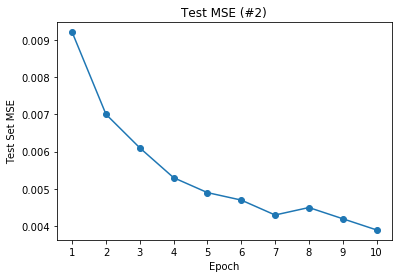

In [99]:
test2_mse = np.array([0.0092, 0.0070, 0.0061, 0.0053, 0.0049, 0.0047, 0.0043, 0.0045, 0.0042, 0.0039])
mse_plot("Test MSE (#2)", test2_mse)

In [18]:
x_pred2 = autoencoder2.predict(x_test_noisy)
min10_2, max10_2 = mse_gen(x_test, x_pred2)


Best 10

Row 1: Original Images
Row 2: Reconstructed Images


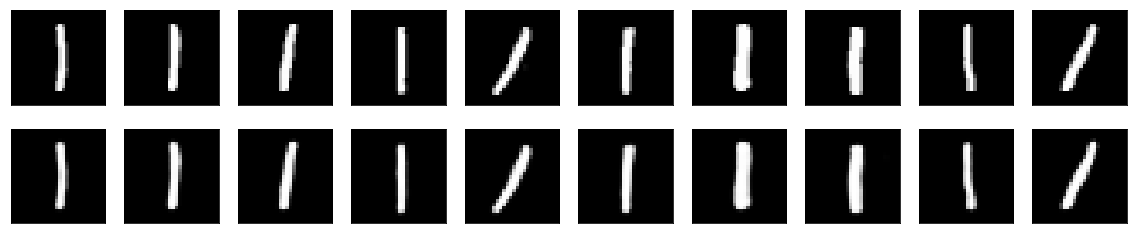

In [19]:
plt_best_worst(10, x_test, x_pred2, min10_2, "Best 10")


Worst 10

Row 1: Original Images
Row 2: Reconstructed Images


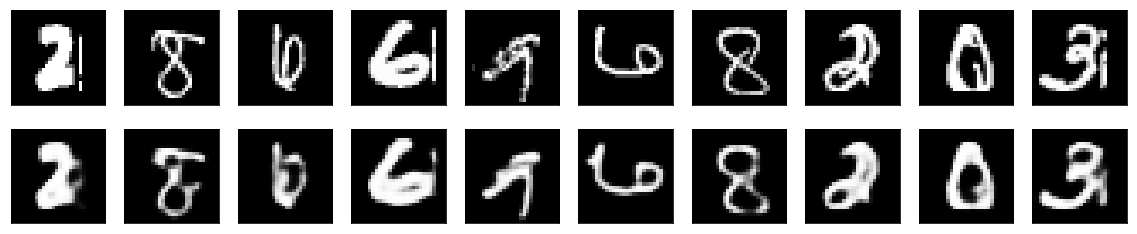

In [20]:
plt_best_worst(10, x_test, x_pred2, max10_2, "Worst 10")

## CNN 3 (optimizer changed)

In [59]:
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x3 = MaxPooling2D((2, 2), padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
encoded3 = MaxPooling2D((2, 2), padding='same')(x3)

x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded3)
x3 = UpSampling2D((2, 2))(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = UpSampling2D((2, 2))(x3)
decoded3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x3)

autoencoder3 = Model(input_img, decoded3)
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

In [60]:
autoencoder3.fit(x_train_noisy, np.concatenate((x_train, x_train)),
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder3')],
                verbose=2)

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
262s - loss: 0.0997 - mean_squared_error: 0.0125 - val_loss: 0.0765 - val_mean_squared_error: 0.0052
Epoch 2/10
261s - loss: 0.0748 - mean_squared_error: 0.0046 - val_loss: 0.0724 - val_mean_squared_error: 0.0039
Epoch 3/10
251s - loss: 0.0722 - mean_squared_error: 0.0038 - val_loss: 0.0708 - val_mean_squared_error: 0.0035
Epoch 4/10
252s - loss: 0.0709 - mean_squared_error: 0.0034 - val_loss: 0.0699 - val_mean_squared_error: 0.0032
Epoch 5/10
266s - loss: 0.0701 - mean_squared_error: 0.0032 - val_loss: 0.0702 - val_mean_squared_error: 0.0033
Epoch 6/10
251s - loss: 0.0695 - mean_squared_error: 0.0030 - val_loss: 0.0688 - val_mean_squared_error: 0.0029
Epoch 7/10
254s - loss: 0.0690 - mean_squared_error: 0.0029 - val_loss: 0.0689 - val_mean_squared_error: 0.0029
Epoch 8/10
250s - loss: 0.0686 - mean_squared_error: 0.0028 - val_loss: 0.0682 - val_mean_squared_error: 0.0027
Epoch 9/10
249s - loss: 0.0683 - mean_squared_error: 

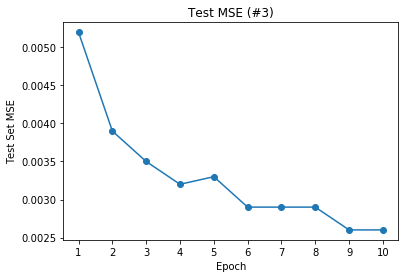

In [100]:
test3_mse = np.array([0.0052, 0.0039, 0.0035, 0.0032, 0.0033, 0.0029, 0.0029, 0.0029, 0.0026, 0.0026])
mse_plot("Test MSE (#3)", test3_mse)

In [61]:
x_pred3 = autoencoder3.predict(x_test_noisy)
min10_3, max10_3 = mse_gen(x_test, x_pred3)


Best 10

Row 1: Original Images
Row 2: Reconstructed Images


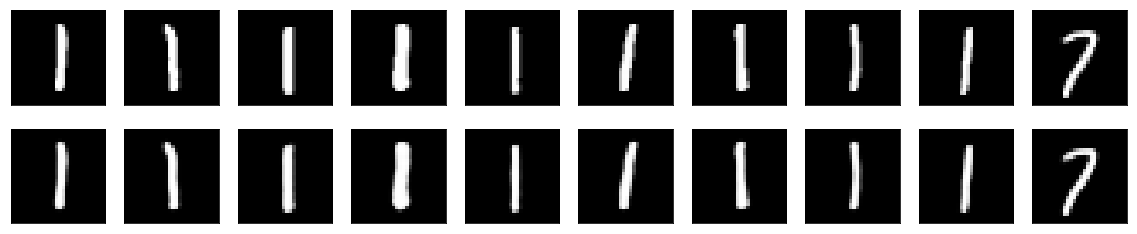

In [62]:
plt_best_worst(10, x_test, x_pred3, min10_3, "Best 10")


Worst 10

Row 1: Original Images
Row 2: Reconstructed Images


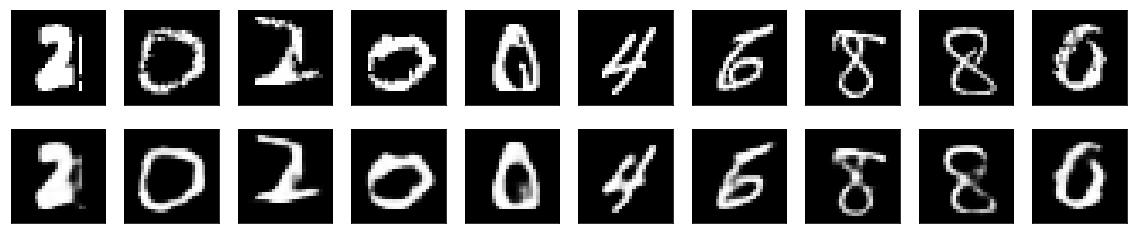

In [63]:
plt_best_worst(10, x_test, x_pred3, max10_3, "Worst 10")

## CNN 4 (# of layers changed)

In [77]:
x4 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x4 = MaxPooling2D((2, 2), padding='same')(x4)
x4 = Conv2D(8, (3, 3), activation='relu', padding='same')(x4)
x4 = MaxPooling2D((2, 2), padding='same')(x4)
x4 = Conv2D(8, (3, 3), activation='relu', padding='same')(x4)
encoded4 = MaxPooling2D((2, 2), padding='same')(x4)


x4 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded4)
x4 = UpSampling2D((2, 2))(x4)
x4 = Conv2D(8, (3, 3), activation='relu', padding='same')(x4)
x4 = UpSampling2D((2, 2))(x4)
x4 = Conv2D(16, (3, 3), activation='relu')(x4)
x4 = UpSampling2D((2, 2))(x4)
decoded4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x4)

autoencoder4 = Model(input_img, decoded4)
autoencoder4.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

In [78]:
autoencoder4.fit(x_train_noisy, np.concatenate((x_train, x_train)),
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder4')],
                verbose=2)

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
148s - loss: 0.2074 - mean_squared_error: 0.0495 - val_loss: 0.1630 - val_mean_squared_error: 0.0347
Epoch 2/10
148s - loss: 0.1510 - mean_squared_error: 0.0302 - val_loss: 0.1458 - val_mean_squared_error: 0.0286
Epoch 3/10
144s - loss: 0.1386 - mean_squared_error: 0.0258 - val_loss: 0.1336 - val_mean_squared_error: 0.0242
Epoch 4/10
294s - loss: 0.1307 - mean_squared_error: 0.0230 - val_loss: 0.1261 - val_mean_squared_error: 0.0215
Epoch 5/10
155s - loss: 0.1251 - mean_squared_error: 0.0211 - val_loss: 0.1195 - val_mean_squared_error: 0.0193
Epoch 6/10
151s - loss: 0.1206 - mean_squared_error: 0.0196 - val_loss: 0.1177 - val_mean_squared_error: 0.0187
Epoch 7/10
155s - loss: 0.1181 - mean_squared_error: 0.0187 - val_loss: 0.1153 - val_mean_squared_error: 0.0178
Epoch 8/10
153s - loss: 0.1161 - mean_squared_error: 0.0180 - val_loss: 0.1153 - val_mean_squared_error: 0.0180
Epoch 9/10
149s - loss: 0.1142 - mean_squared_error: 

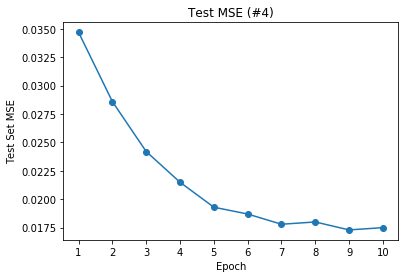

In [101]:
test4_mse = np.array([0.0347, 0.0286, 0.0242, 0.0215, 0.0193, 0.0187, 0.0178, 0.0180, 0.0173, 0.0175])
mse_plot("Test MSE (#4)", test4_mse)

In [80]:
x_pred4 = autoencoder4.predict(x_test_noisy)
min10_4, max10_4 = mse_gen(x_test, x_pred4)


Best 10

Row 1: Original Images
Row 2: Reconstructed Images


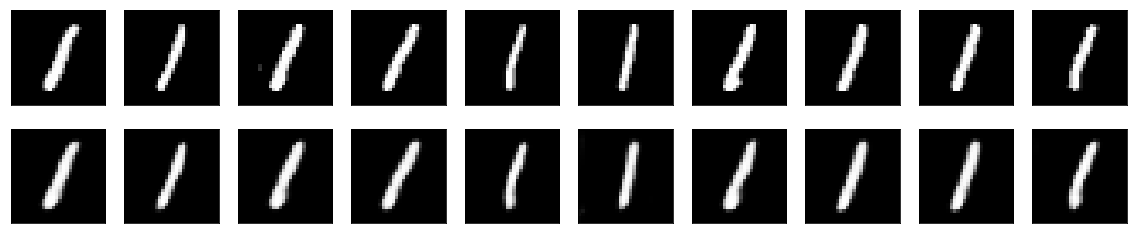

In [81]:
plt_best_worst(10, x_test, x_pred4, min10_4, "Best 10")


Worst 10

Row 1: Original Images
Row 2: Reconstructed Images


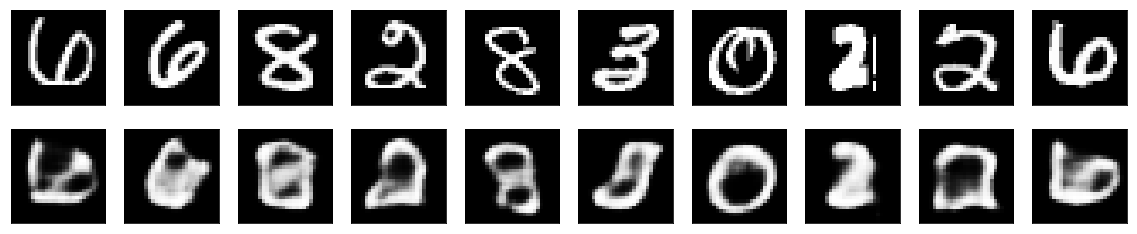

In [82]:
plt_best_worst(10, x_test, x_pred4, max10_4, "Worst 10")